In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# import libraries and set display options
import pandas as pd
import pprint

# set frame width and center output
from IPython.core.display import display, HTML
display(HTML("""
<style>
.container {width:84% !important;
}
</style>
"""))

# pretty print options
pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 3000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

# open file
x_rates = pd.read_csv("euro-daily-hist_1999_2020.csv")

# head, tail, and basic info
# display(x_rates.head())
# display(x_rates.tail())
# display(x_rates.info())

In [3]:
# strip brackets and trailing space from country names
# replace remaining space with underscore
# lower case all column names
x_rates.columns = x_rates.columns.str.replace("[","").str.replace("]","")
x_rates.columns = x_rates.columns.str.rstrip()
x_rates.columns = x_rates.columns.str.replace(" ","_")
x_rates.columns = x_rates.columns.str.lower()

# rename columns
x_rates.rename(columns={"period\\unit:":"date",
                        "chinese_yuan_renminbi":"chinese_yuan",
                        "uk_pound_sterling":"uk_pound"}, inplace=True)

# convert datetime
x_rates["date"] = pd.to_datetime(x_rates["date"])

# resort and reindex
x_rates.sort_values("date", inplace=True)
x_rates.reset_index(drop=True, inplace=True)

# convert hyphens in currency columns to NaN
import numpy as np
x_rates = x_rates.replace("-", np.nan)

# convert exchange rate values to float
x_rates.iloc[:,1:] = x_rates.iloc[:,1:].astype(float)

/var/folders/bz/5cj1tzbj5xn319rpqrw6gpmh0000gn/T/ipykernel_35244/4286603551.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_rates.columns = x_rates.columns.str.replace("[","").str.replace("]","")


In [4]:
# create a us dollar to euro dataframe and add 30 day rolling mean column
us_dollar = x_rates[["date","us_dollar"]].copy()
us_dollar["rolling_mean_30"] = us_dollar["us_dollar"].rolling(30).mean()

# line graph for dollar to euro exchange rate
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.dates as mdates
plt.style.use('ggplot') # set style for graphs


In [5]:
# create nan group and get dates
nan_dollar_group = us_dollar[us_dollar["us_dollar"].isnull()]
nan_days = nan_dollar_group["date"]

# create a dollar to euro dataframe with NaN dates removed
US_dollar_nonull = x_rates[x_rates["us_dollar"].notna()].copy()
US_dollar_nonull["rolling_mean_30"] = US_dollar_nonull["us_dollar"].rolling(30).mean()

# line graph showing dollar to euro showing NaN values with and without highlight


In [6]:
# import colormap and set up color iteration
from matplotlib.pyplot import cm
colors = iter([plt.cm.tab10(i) for i in range(8)])

# create a list of data frames for each currency with log rate of the exchange rate, 30 day rolling mean, and year
df_dict = {}
for currency in x_rates.columns[1:]:
    df_name = currency
    df = x_rates[["date", currency]].copy()
    df = df[df[currency].notna()]
    df["log_rate"] = np.log(df.iloc[:,1]/df.iloc[:,1].shift()) # getting the log of the exchange rate # double check this is the correct way to get log
    df["rolling_mean_30"] = df[currency].rolling(30).mean()
    df["year"] = df["date"].dt.year
    df_dict[currency] = df

# currencies for comparison
high_freq = [df_dict["us_dollar"], df_dict["japanese_yen"], df_dict["uk_pound"], df_dict["australian_dollar"]]
low_freq = [df_dict["israeli_shekel"], df_dict["philippine_peso"], df_dict["malaysian_ringgit"], df_dict["romanian_leu"]]

# line graph showing Euro to each high frequency trading pairs


In [7]:
# line graph showing Euro to four high frequency trading pairs overlapped


In [8]:
# function to create df with year and annual volatility for every row
volatility_df_list = []
def volatizer(currency):
    annual_df_list = [currency[currency['year'] == y] for y in currency['year'].unique()] # list of annual dfs
    c_name = currency.columns[1]
    row_dict = {} # dictionary with year:annual_volatility as key:value 
    for frame in annual_df_list:
        year_name = frame.iat[0,4] # first cell of the "year" column, becomes the "year" key for row_dict
        annual_volatility = frame["log_rate"].std()*253**.5 # volatility measured by standard deviation * 253 trading days per year raised to the 0.5 power
        row_dict[year_name] = annual_volatility # dictionary with year:annual_volatility as key:value 
    df = pd.DataFrame.from_dict(row_dict, orient="index", columns=[c_name]) # new df from dictionary indexing on year
    volatility_df_list.append(df)

# apply volatizer to each currency df
for key in df_dict:
    df_dict[key] = volatizer(df_dict[key])
    
# create an annual volatility data frame with all 40 currencies
annual_volatility = pd.concat(volatility_df_list, axis=1)
annual_volatility["year"] = annual_volatility.index
# move year to position 0 and set index as int

In [9]:
# bar charts comparing volatility for four high and low frequency pairs
high_freq = [annual_volatility["us_dollar"], annual_volatility["japanese_yen"], annual_volatility["uk_pound"], annual_volatility["australian_dollar"]]
low_freq = [annual_volatility["israeli_shekel"], annual_volatility["philippine_peso"], annual_volatility["malaysian_ringgit"], annual_volatility["romanian_leu"]]
years = annual_volatility.iloc[:,40]
colors = iter([plt.cm.tab10(i) for i in range(8)])

# high_freq bar charts


# low_freq bar charts

# plt.show()

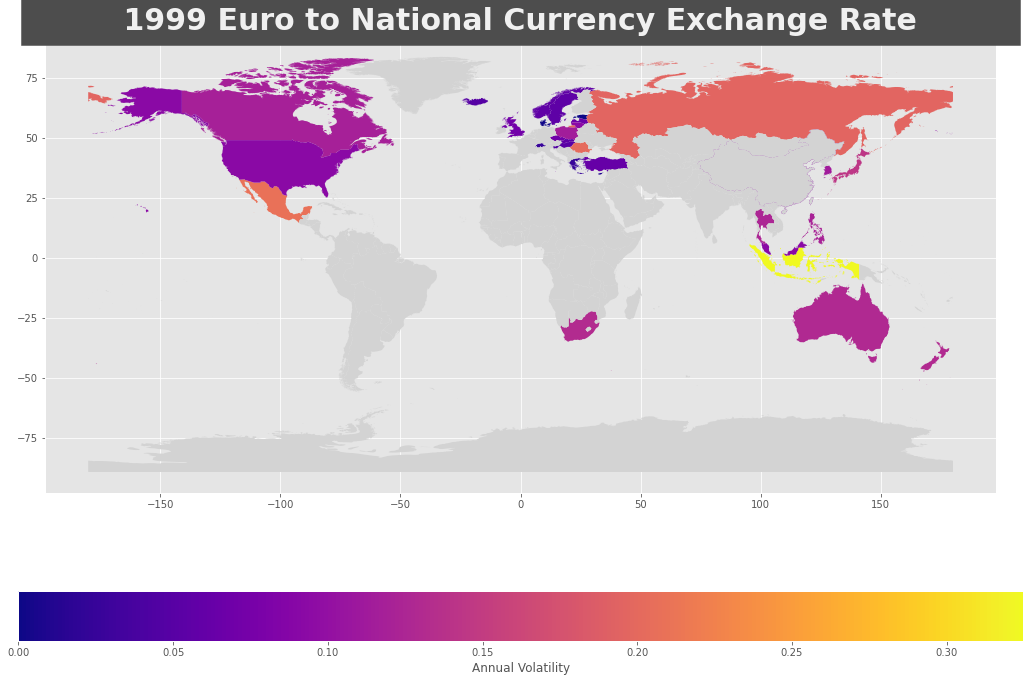

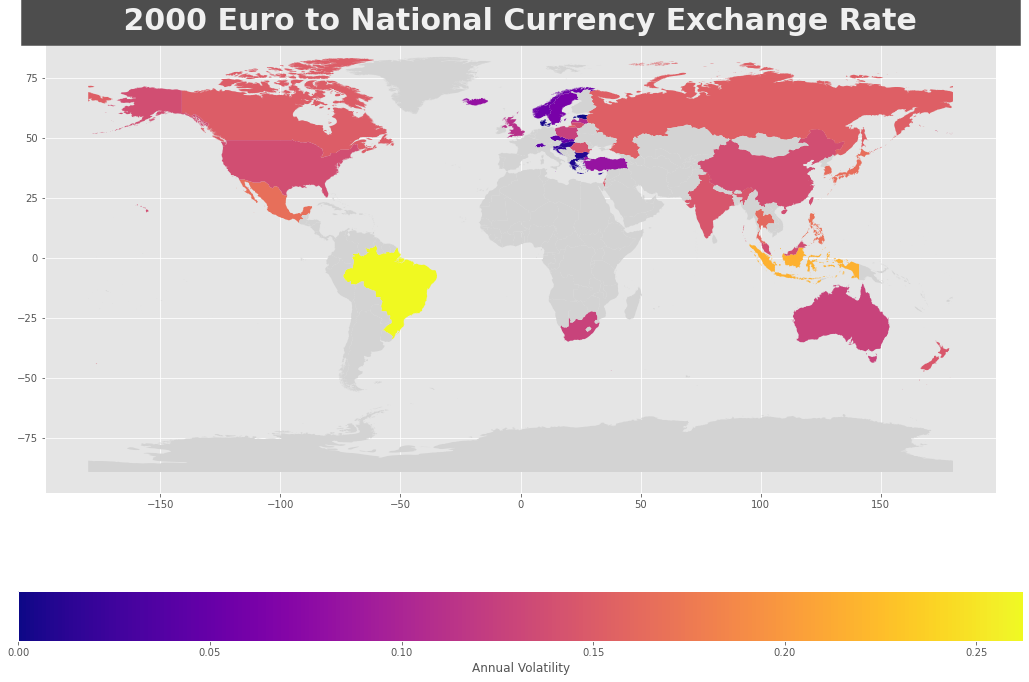

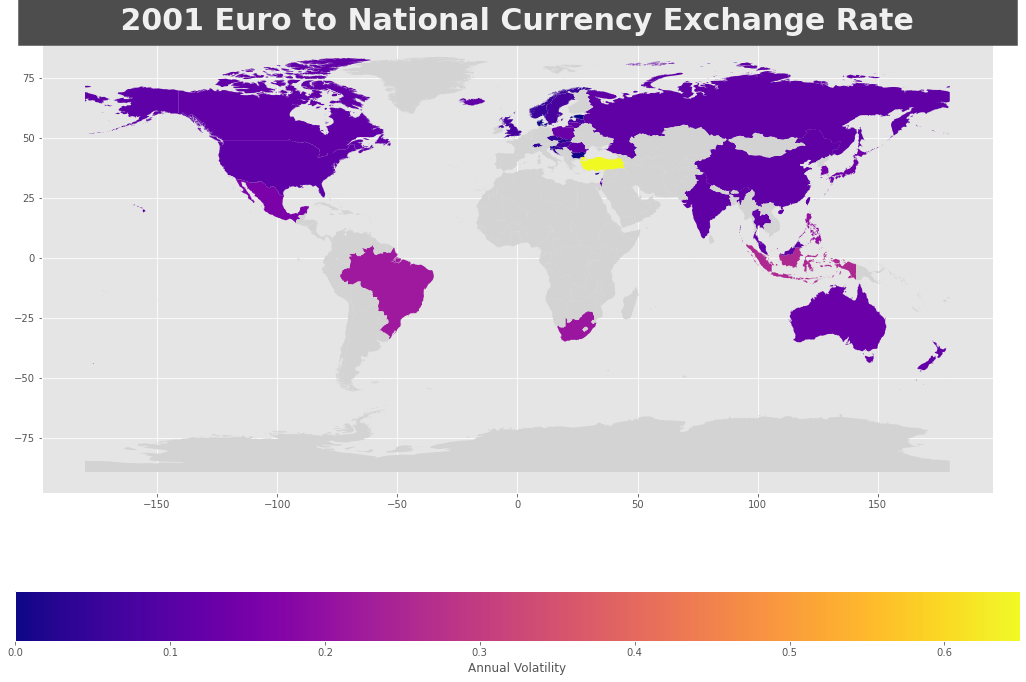

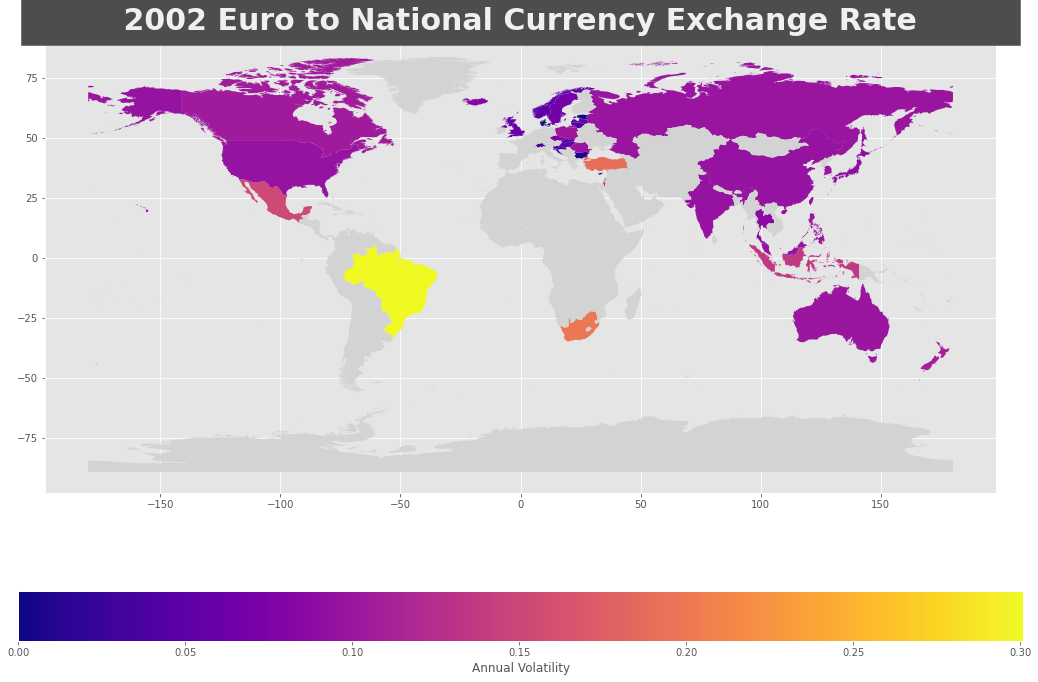

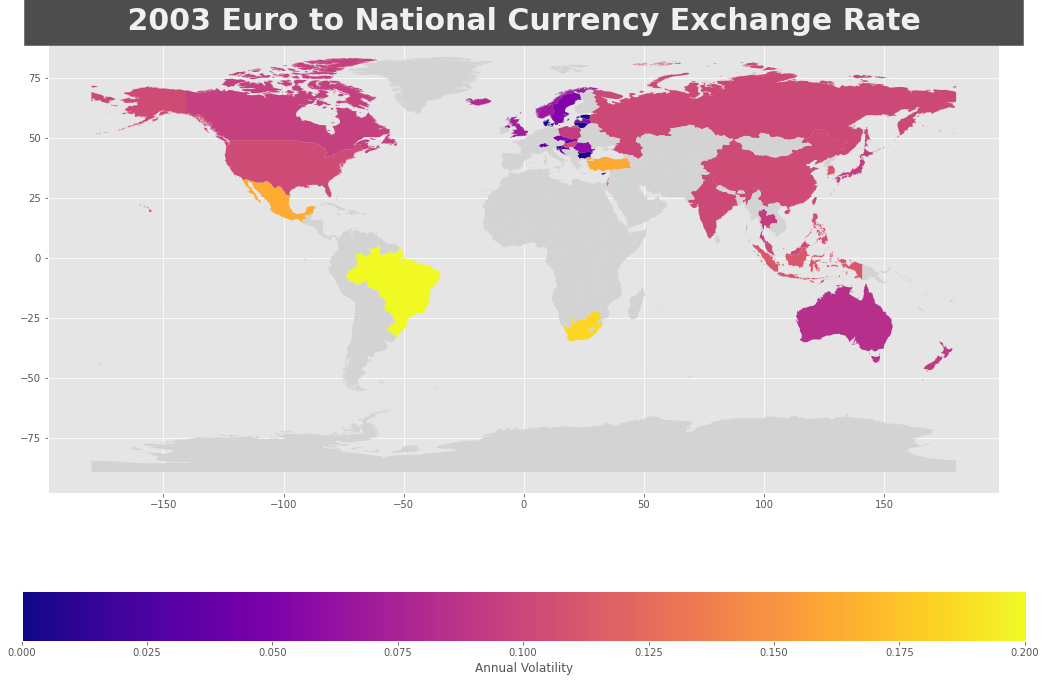

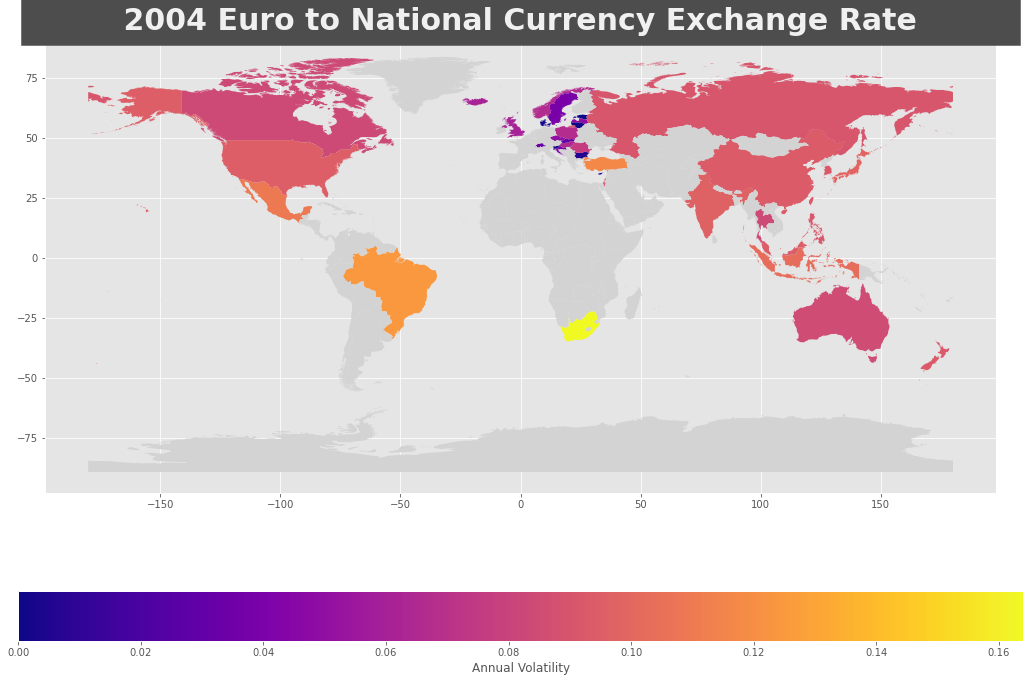

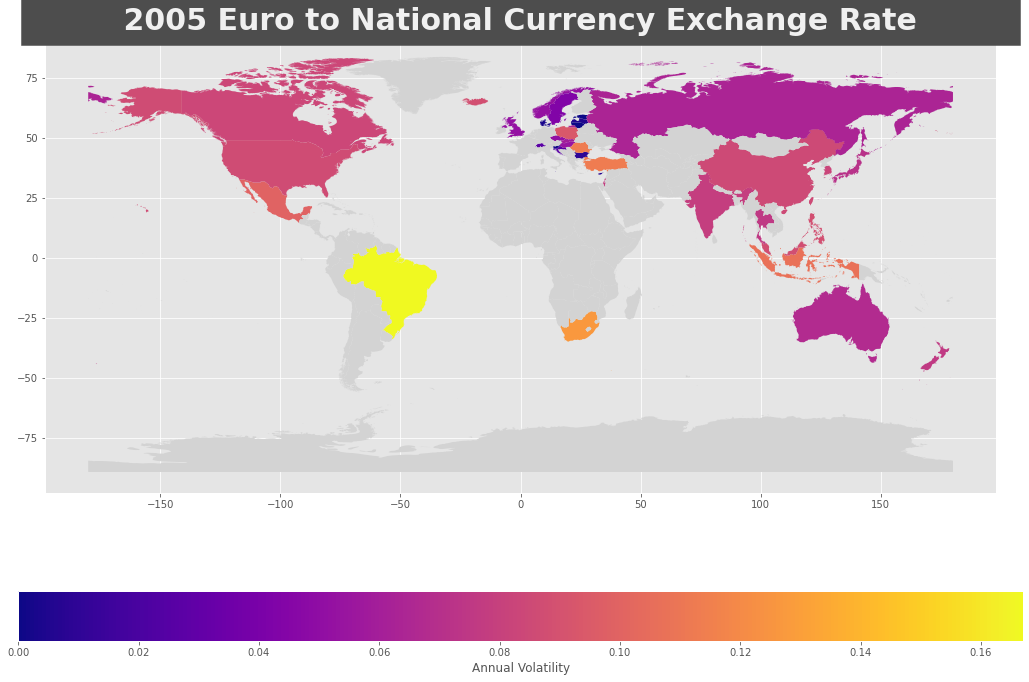

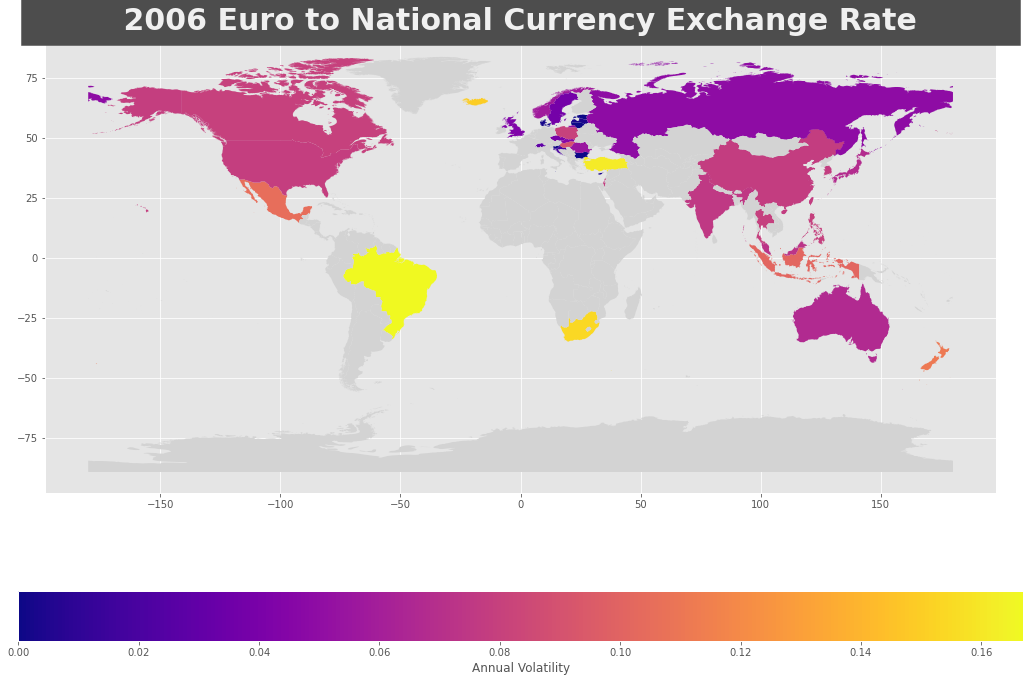

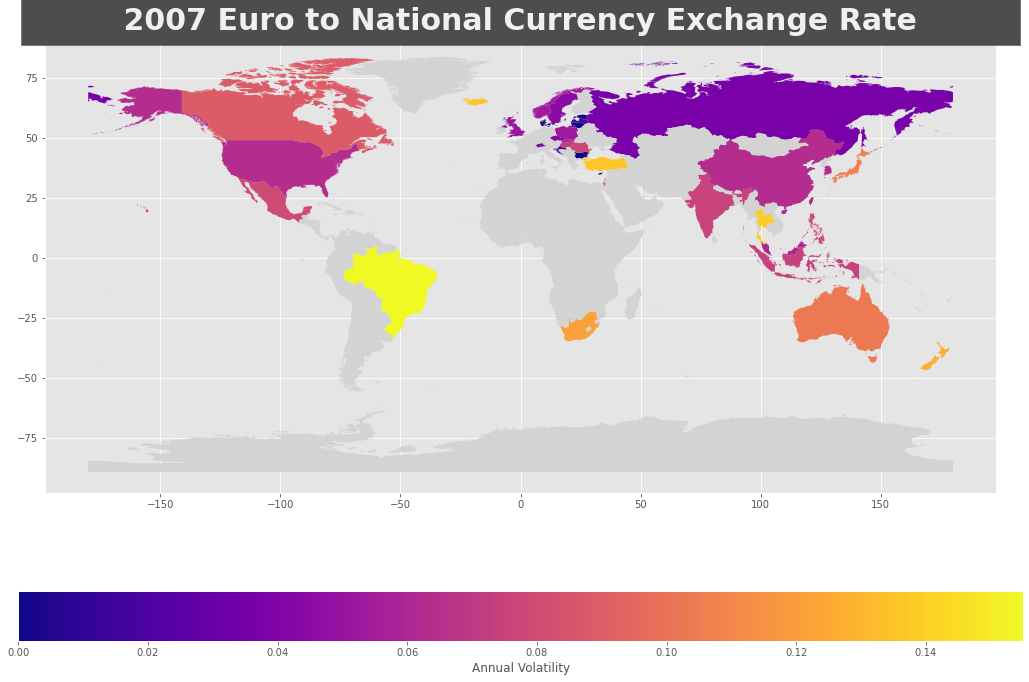

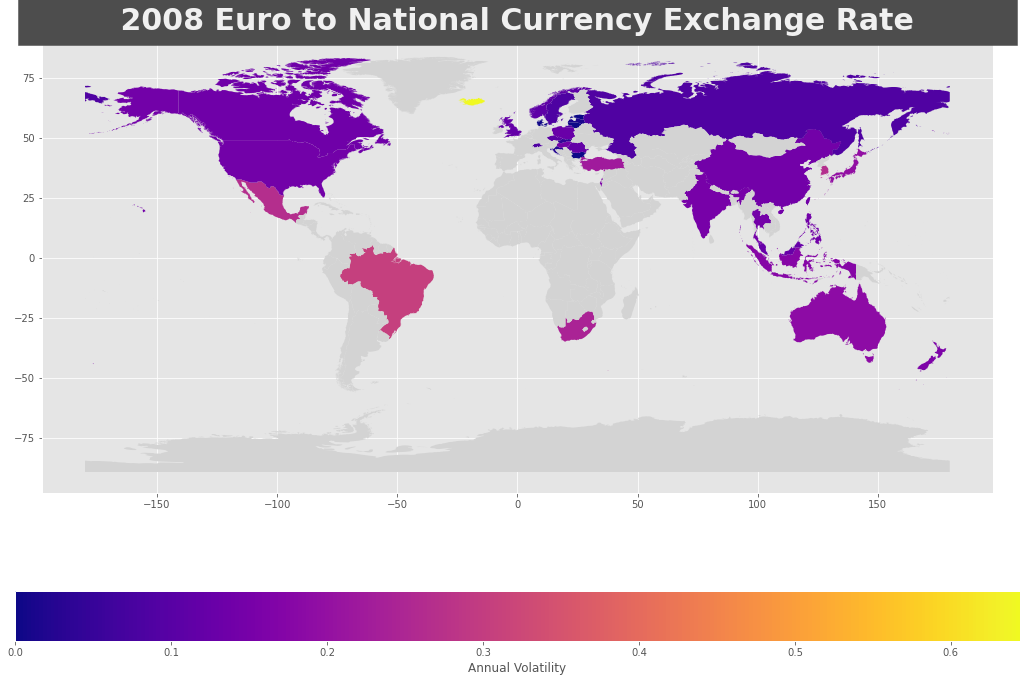

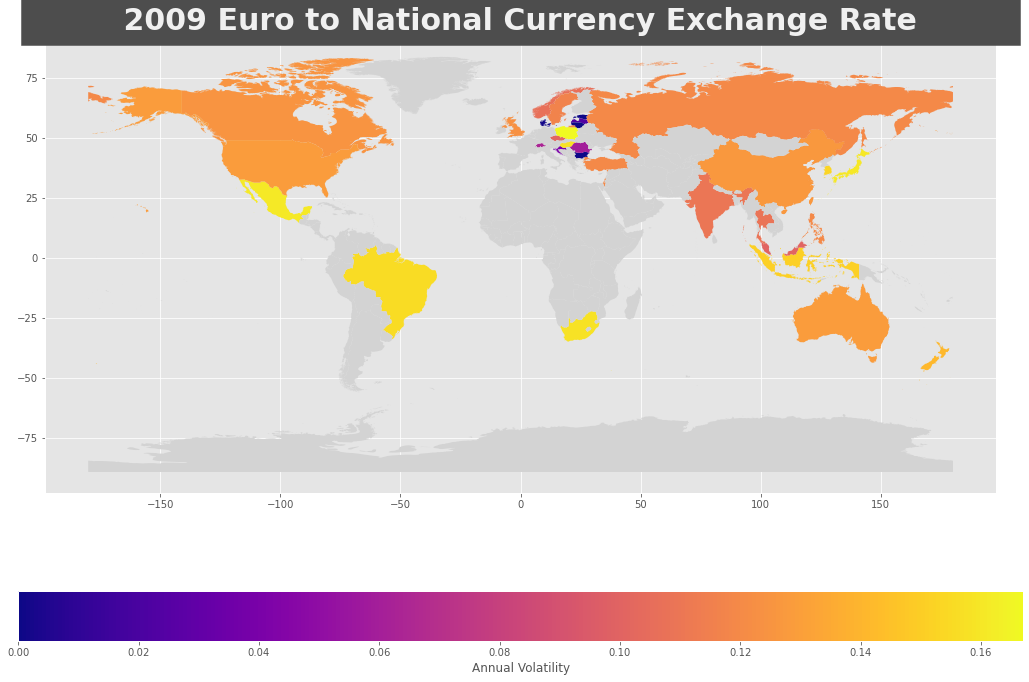

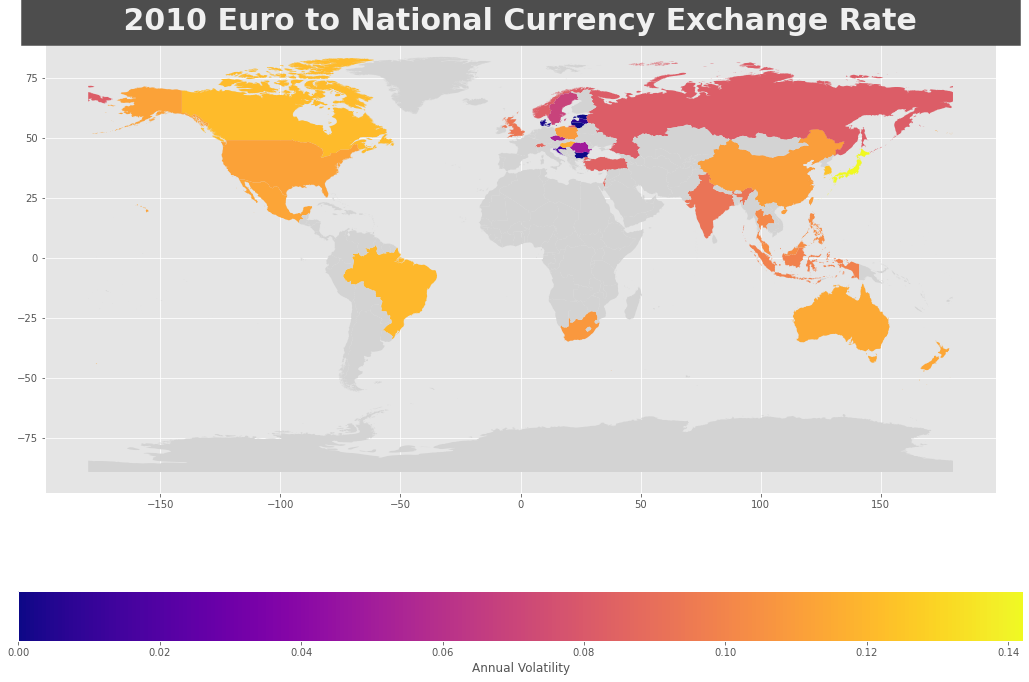

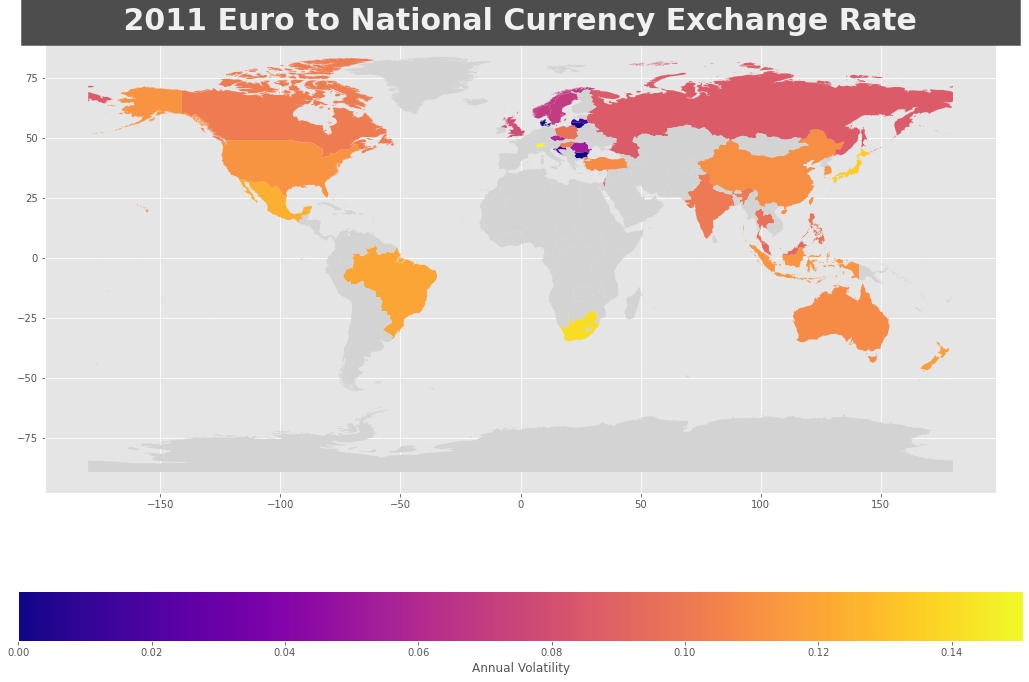

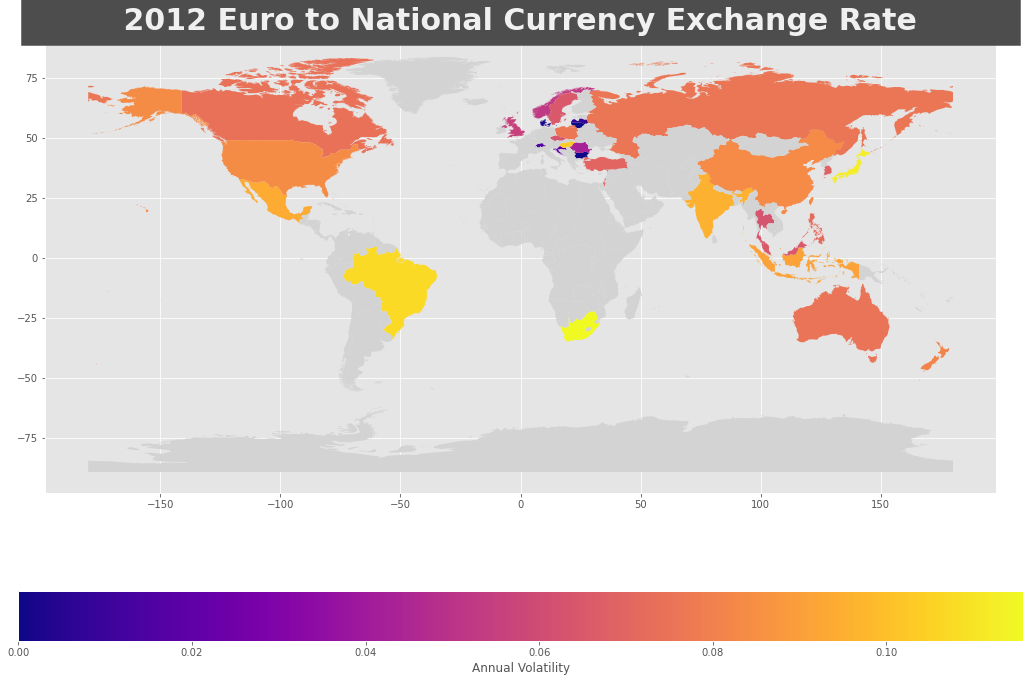

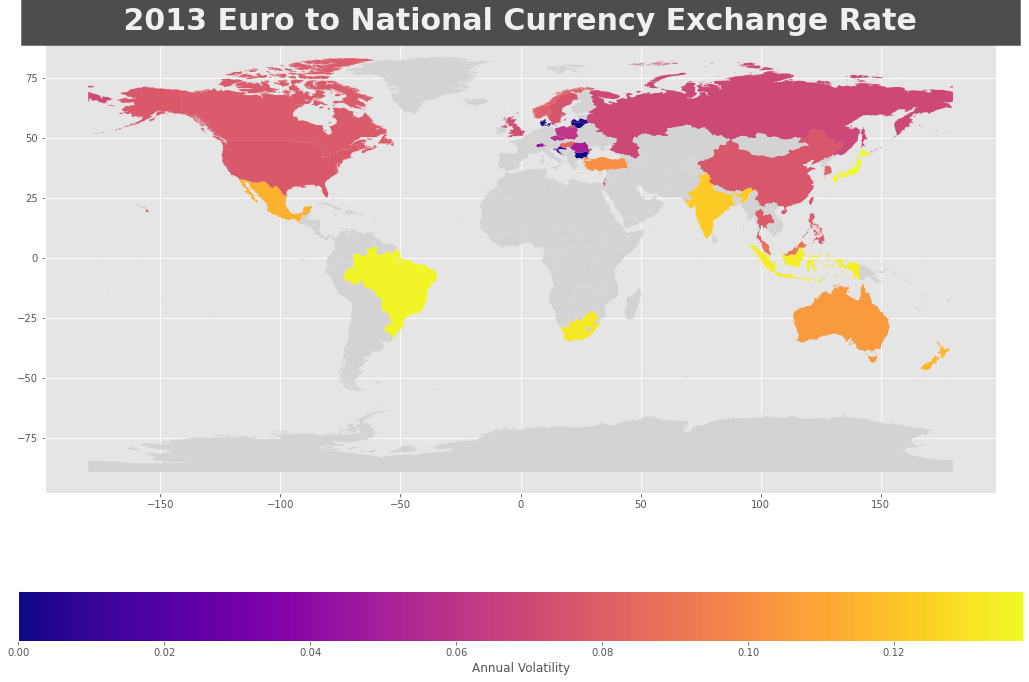

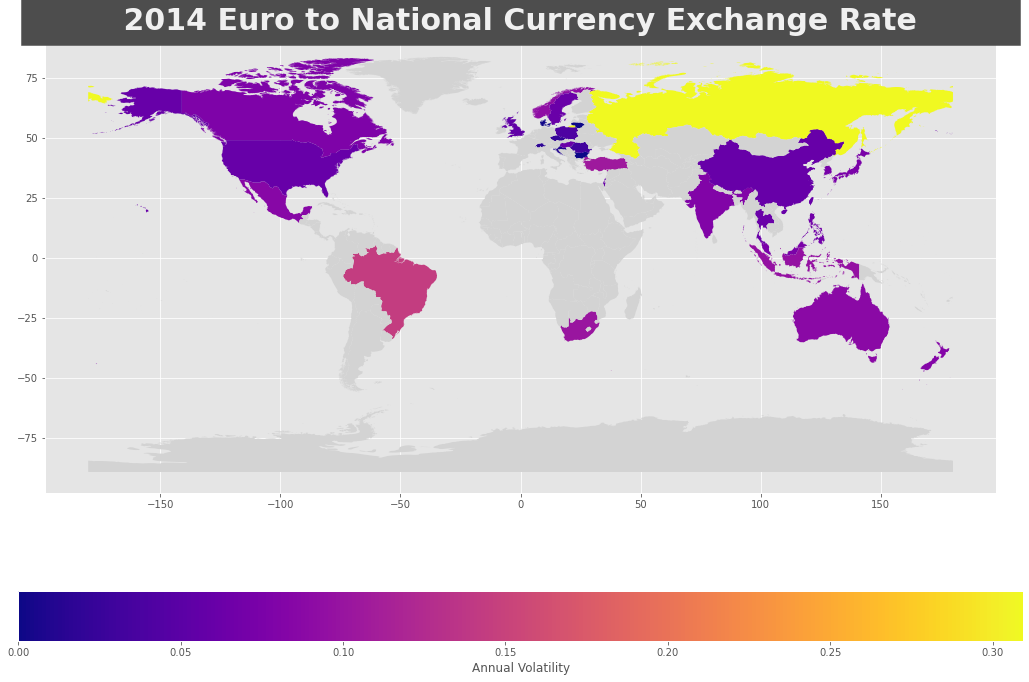

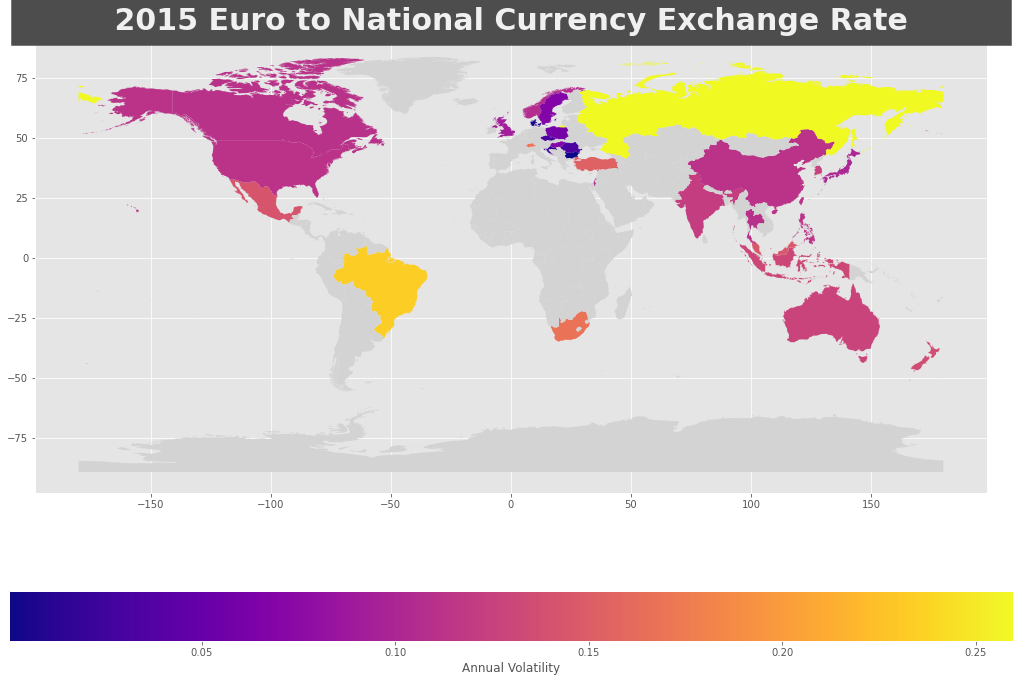

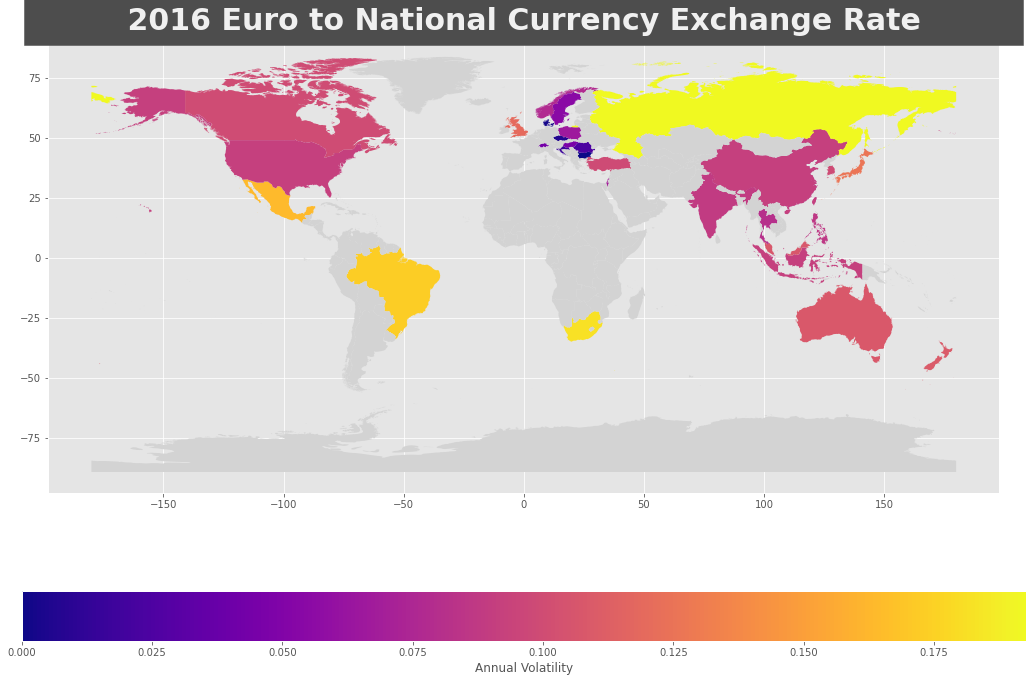

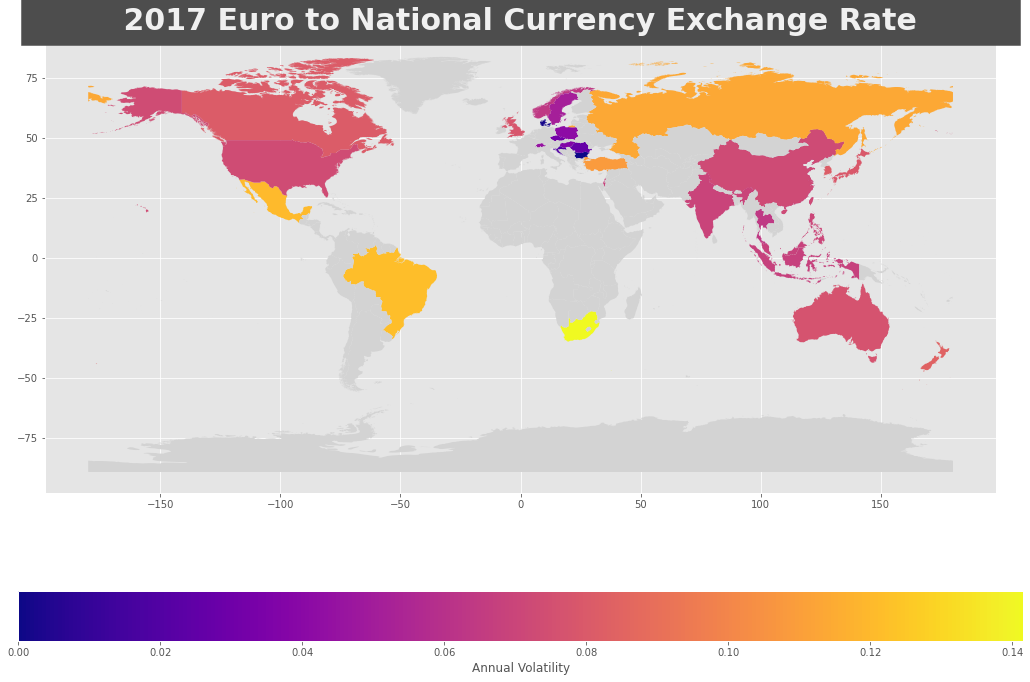

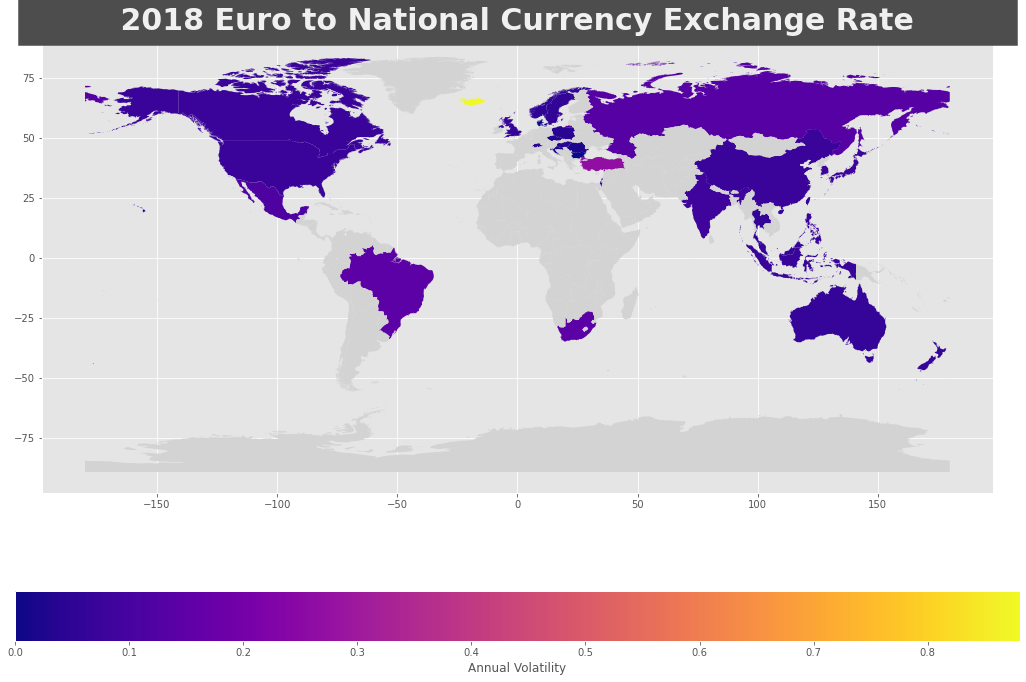

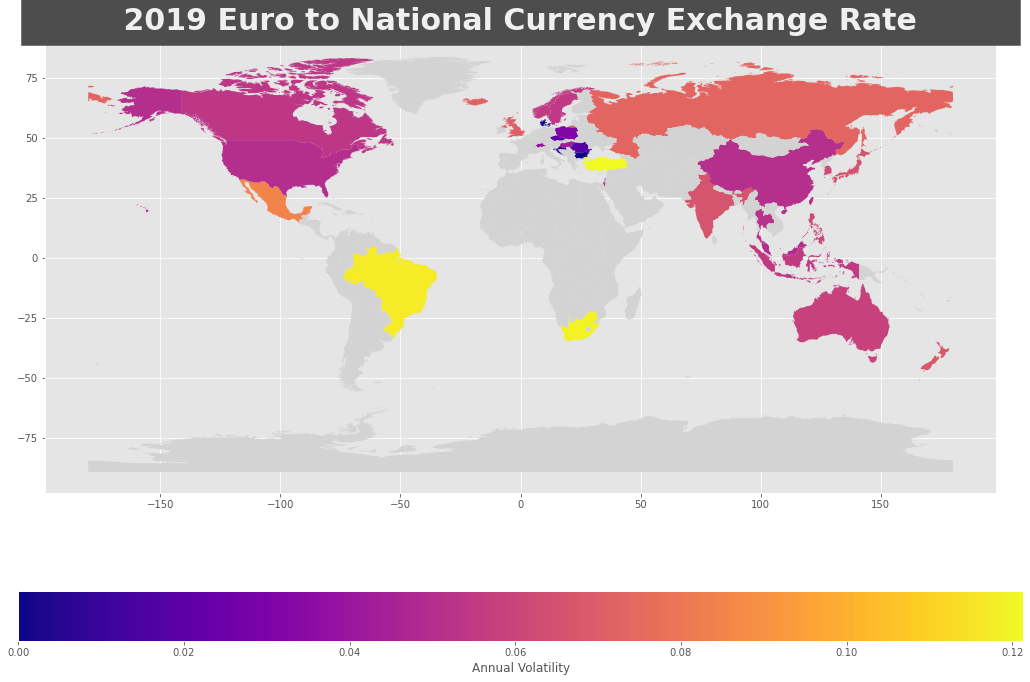

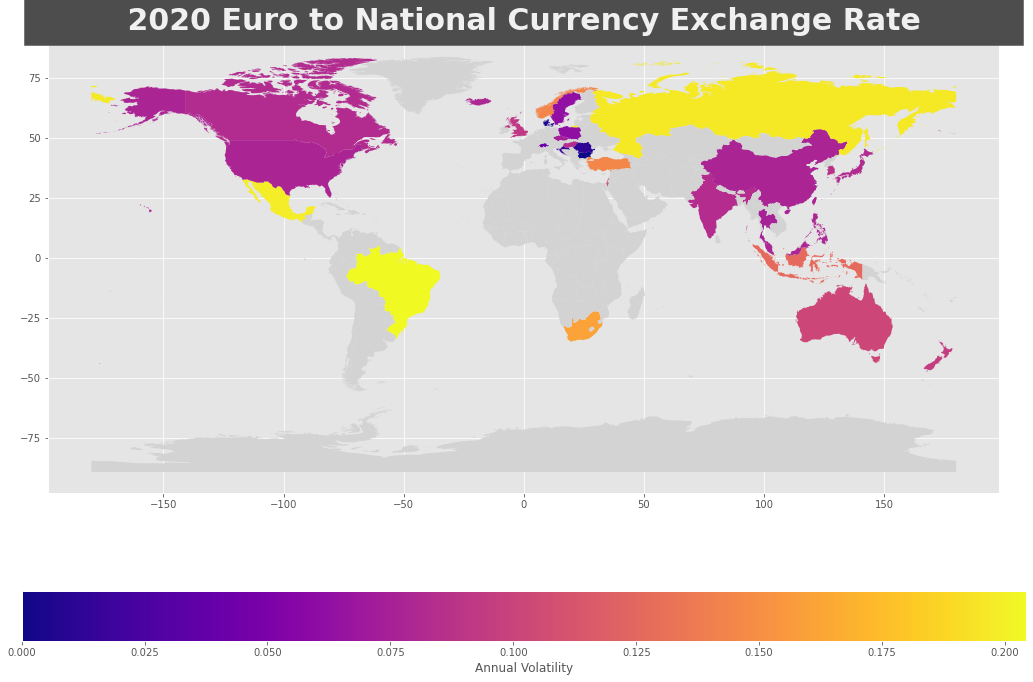

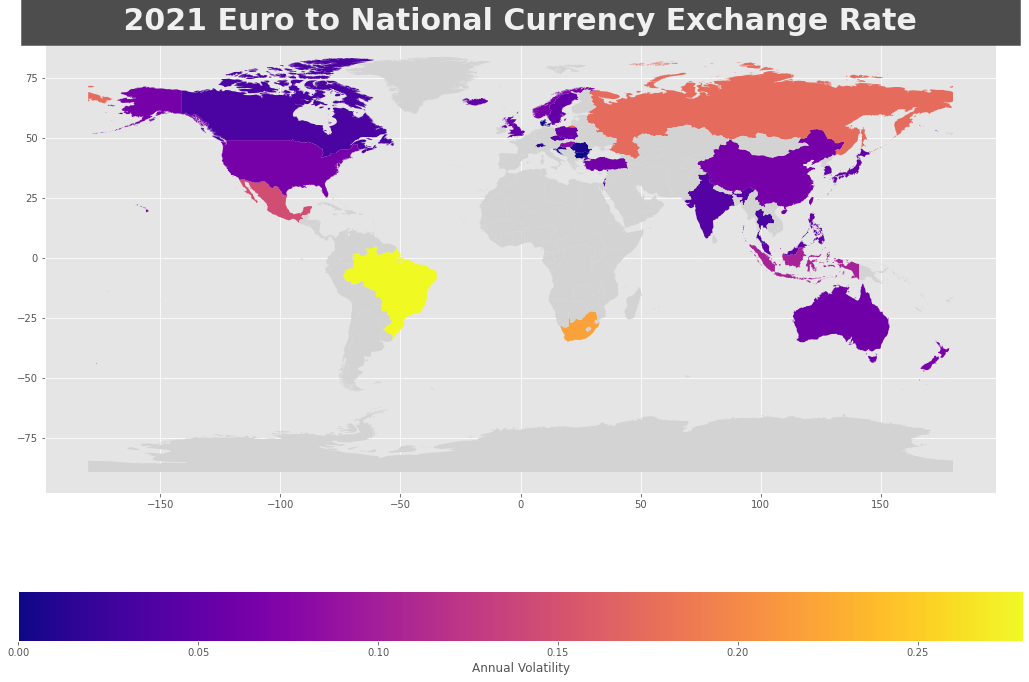

In [10]:
# uncommenting this cell and running in a geopandas environemnt
# will produce a series of downloaded map png files

# this is a very, very kuldge way for me to get the info from
# the annual volatility datasat to the map dataset
av_transposed = annual_volatility.transpose()
av_transposed = av_transposed.drop("year")
iso_list = ["AU","BG","BR","CA","CH","CN","CY","CZ","DK","EE","GB","GR",
            "CN","HR","HU","ID","IL","IN","IS","JP","KR","LT","LV","MT",
            "MX","MY","NO","NZ","PH","PL","RO","RU","SE","SG","SI","SK",
            "TH","TR","US","ZA"]
av_transposed.insert(loc=0, column='iso', value=iso_list)
av_transposed.reset_index(inplace=True)
av_transposed = av_transposed.rename(columns = {'index':'currency'})

# import geopandas and other libraries
#  consider re-writing using geopandas map
# geo_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
import geopandas as gpd
import seaborn as sns
import os
map_data = gpd.read_file("maps/World_Countries__Generalized_.shp")
map_data["Volatility"] = None
concat_map = map_data.merge(av_transposed, left_on="ISO", right_on="iso", how="left")
map_data = concat_map

# make maps for the gif
# replaced -> map_data.plot(column=column, figsize=(18,12), cmap="plasma", missing_kwds=missing_kwds, legend=True, legend_kwds={'label': "Annual Volatility", 'orientation':"horizontal"})
for column in concat_map.iloc[:,11:34]:
    map_name = "map_"+str(column)
    map_data.plot(column=column, figsize=(18,12), cmap="plasma", legend=True, missing_kwds={'color': 'lightgrey'},
                         legend_kwds={'label': "Annual Volatility", 'orientation':"horizontal"})
    plt.title(" "*9 + str(column) + " Euro to National Currency Exchange Rate" + " "*9,
             color = "#f0f0f0", backgroundcolor = "#4d4d4d", fontsize=30, weight="bold")
#     plt.text(0.0, 0.0, "© B McMinn" + " "*174 + "Source: European Central Bank",
#         color = "#f0f0f0", backgroundcolor = "#4d4d4d", fontsize=14)
    plt.show()

<!-- <img src="map_gif.gif" width="950" align="center"> -->